In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import numpy as np
from sympy.printing.pretty.pretty_symbology import line_width

In [3]:
raw_df = pd.read_csv('../data/boston.txt',sep=r"\s+",skiprows=22,header=None)
data = np.hstack([raw_df.values[::2,:],raw_df.values[1::2,:2]])
target = raw_df.values[1::2,2]
X_full,y_full = data,target

In [4]:
n_samples = X_full.shape[0]
n_features = X_full.shape[1]

In [5]:
rng = np.random.RandomState(1210)

In [6]:
missing_rate = 0.5
n_missing_samples = int(np.floor(n_samples * n_features * missing_rate))#向下取整之后的整数

In [7]:
missing_features = rng.randint(0,n_features,n_missing_samples)

In [8]:
missing_samples = rng.randint(0,n_samples,n_missing_samples)

In [9]:
X_missing = X_full.copy()

In [10]:
y_missing = y_full.copy()

In [11]:
X_missing[missing_samples,missing_features] = np.nan

In [12]:
X_missing = pd.DataFrame(X_missing)

In [13]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan,strategy='mean')
X_missing_mean = imp_mean.fit_transform(X_missing)

In [14]:
imp_0 = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0)#constant指定是固定值,fill_value表示的是什么值
X_missing_0 = imp_0.fit_transform(X_missing)

In [148]:
type(X_missing_mean)

numpy.ndarray

In [15]:
X_missing_reg = X_missing.copy()

In [16]:
sort_index = np.argsort(X_missing_reg.isna().sum(axis = 0)).values

In [17]:
sort_index

array([ 1,  4,  7,  8,  5, 12, 10,  9,  2,  6, 11,  0,  3], dtype=int64)

In [18]:
#训练模型来得到
from sklearn.ensemble import RandomForestRegressor
for i in sort_index:
    df = X_missing_reg 
    fillc = df.iloc[:,i] #得到每个列索引的值
    df_ = pd.concat([df.loc[:,df.columns != 1],pd.DataFrame(y_full)],axis=1)#将不是该列的和target值合并,用于预测该列的值
    df_0 = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0).fit_transform(df_)#将空值用0来填充
    #非空值来预测空值
    y_train = fillc[fillc.notnull()]
    y_test = fillc[fillc.isna()]
    X_train = df_0[y_train.index,:]
    X_test = df_0[y_test.index,:]
    rfg = RandomForestRegressor(random_state=1210)
    rfg.fit(X_train,y_train)
    y_pred = rfg.predict(X_test)
    X_missing_reg.loc[y_test.index,i] = y_pred

In [35]:
#用0填充的,
from sklearn.model_selection import cross_val_score
X = [X_full,X_missing_mean,X_missing_0,X_missing_reg]
mse_list = []
r2_list = []
for x in X:
    rfg = RandomForestRegressor(random_state=1210,n_estimators=100)
    score = cross_val_score(rfg,x,y_full,scoring='neg_mean_squared_error',cv=5).mean()
    score_r2 = cross_val_score(rfg,x,y_full,scoring='r2',cv=5).mean()
    mse_list.append(score*-1)
    r2_list.append(score_r2*-1)

In [33]:
import matplotlib.pyplot as plt

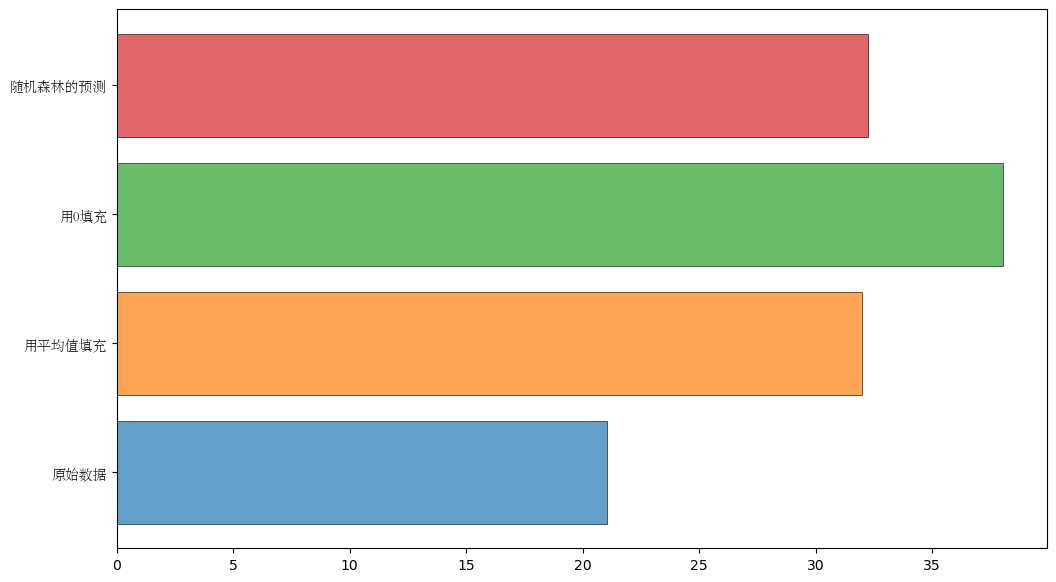

In [36]:
X_labels = ['原始数据','用平均值填充','用0填充','随机森林的预测']
plt.figure(figsize=(12,7))
ax = plt.subplot(111)
for i in range(len(X_labels)):
    ax.barh(i,mse_list[i],alpha = .7,edgecolor = 'black',linewidth = .6,align='center')
ax.set_yticks(np.arange(len(mse_list)))
ax.set_yticklabels(X_labels,fontproperties = 'STsong')
plt.show()